### $\sigma_z$, $z_{50}$, metalicidad y SFR vs age para distintos radios


In [3]:
import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import numpy as np
import time_conversion as time
import z50 as z50_prof
import velocity_dispersion as vd
import z50

ID = np.loadtxt('../_data/my_halos.dat')[:,0]

path = '/store/erebos/omarioni/_simulations/snap_127/'

for i in range(14):

    snap = h5py.File(path + 'subhalo_'+str('%d'%ID[i])+'.h5py', 'r')

    print('subhalo_'+str('%d'%ID[i]))

    aexp = snap['/Time'][()]
    h    = snap['/h'][()]
    Rvir = snap['/R200'][()]
    Om_L = snap['/Omega_Lambda'][()]
    Om_M = snap['/Omega_0'][()]

    pstr = snap['/Str/Coordinates'][()]
    mstr = snap['/Str/Masses'][()]
    vstr = snap['/Str/Velocities'][()]

    met  = snap['/Str/Total_Metallicity'][()]
    sft  = snap['/Str/FormationTime'][()]

    amask, = np.where(sft>0) #aca puede haber particulas con age<0, esas no son estrellas son gas cells.
    ages = time.conv2(sft[amask], h, Om_L, Om_M) #transformo el tiempo de formacion de factor de escala a Gyr
    age  = np.max(ages) - ages #lo resto asi saco la edad de las particulas (inverso al tiempo de form)

    Ztot = met[amask]/0.0127 #para pasarlo a metalicidad solar (ver Illustris data)

    xstr = pstr[amask,0]*aexp/h
    ystr = pstr[amask,1]*aexp/h
    zstr = pstr[amask,2]*aexp/h
    rstr = np.sqrt(xstr**2+ystr**2+zstr**2)

    v_x = vstr[amask,0] *np.sqrt(aexp)
    v_y = vstr[amask,1] *np.sqrt(aexp)
    v_z = vstr[amask,2] *np.sqrt(aexp)

    #----------------------masas----------------------------
    mstr = mstr[amask]*1e10/h

    rgal = 0.15*Rvir*aexp/h

    limit, = np.where(rstr < rgal)
    rsort = np.argsort(rstr[limit])
    Mc = np.cumsum(mstr[limit][rsort])
    Mgal = Mc[-1]
    limit50, = np.where(Mc < Mgal/2)
    r50 = rstr[limit][rsort][limit50][-1]
    
    veloc,=np.where(rstr < r50/2.)

    #----------componentes de la velocidad del centro de masa------------
    vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

    vx = v_x - vxcm
    vy = v_y - vycm
    vz = v_z - vzcm

    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,r50/2.)

    xn_str = e1x*xstr + e1y*ystr + e1z*zstr
    yn_str = e2x*xstr + e2y*ystr + e2z*zstr
    zn_str = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz
    
    Rn_str = np.sqrt(xn_str**2 + yn_str**2)

    Id = ''
    for aux in list(str('%d'%ID[i]))[-2:]:
        Id += aux
    
    radius = (r50/4, r50/2, r50, r50+r50/2, r50*2)
    
    age_bin = np.linspace(0,14,20)
    
    for k in range(len(radius)):
        
        gal, = np.where((Rn_str < radius[k]+1) & (Rn_str > radius[k]-1) & (zn_str < 5) & (zn_str > -5))
        
        w0, = np.where(Ztot[gal]>0)
    
        edad  = age[gal][w0]
        x_str = xn_str[gal][w0]
        y_str = yn_str[gal][w0]
        z_str = zn_str[gal][w0]
        Z_tot = Ztot[gal][w0]
        m_str = mstr[gal][w0]

        age_bin = np.linspace(0,14,20)

        sigma_z = np.zeros(len(age_bin)-1)*np.nan
        edades  = np.zeros(len(age_bin)-1)*np.nan
        met     = np.zeros(len(age_bin)-1)*np.nan
        z_50    = np.zeros(len(age_bin)-1)*np.nan
        SFR     = np.zeros(len(age_bin)-1)*np.nan
        SigSFR  = np.zeros(len(age_bin)-1)*np.nan

        area = np.pi*2*radius[k] #esto me queda de la dif (R+1)**2-(R-1)**2
    
        for j in range(len(age_bin)-1):
            age_lim, = np.where((edad>age_bin[j]) & (edad<age_bin[j+1]))

            if len(age_lim)<2:
                continue

            edades[j] = np.median(edad[age_lim])
            sigma_z[j] = vd.vel_disp(vzn[gal][w0][age_lim])
            z_50[j] = z50.z50v(z_str[age_lim],m_str[age_lim])
            met[j] = np.median(Z_tot[age_lim])

            dt = age_bin[j+1]-age_bin[j]
            Mtot = np.sum(m_str[age_lim])
            SFR[j]  = Mtot/(dt*1e9)
            SigSFR[j] = SFR[j]/area
        
    
        data = np.ndarray([len(age_bin)-1,6])
        data[:,0] = edades
        data[:,1] = sigma_z
        data[:,2] = z_50
        data[:,3] = met
        data[:,4] = SFR
        data[:,5] = SigSFR

        np.savetxt('../_data/Fig3.10/fig3.10_sh'+Id+'_r'+str('%s'%k)+'.dat', data, fmt=('%12.8f','%12.8f','%12.8f','%12.8f','%12.8f','%12.8f'))

subhalo_127000000000002
subhalo_127000000000003
subhalo_127000000000004
subhalo_127000000000006
subhalo_127000000000007
subhalo_127000000000009
subhalo_127000000000012
subhalo_127000000000011
subhalo_127000000000014
subhalo_127000000000020
subhalo_127000000000021
subhalo_127000000000023
subhalo_127000000000028
subhalo_127000000000031


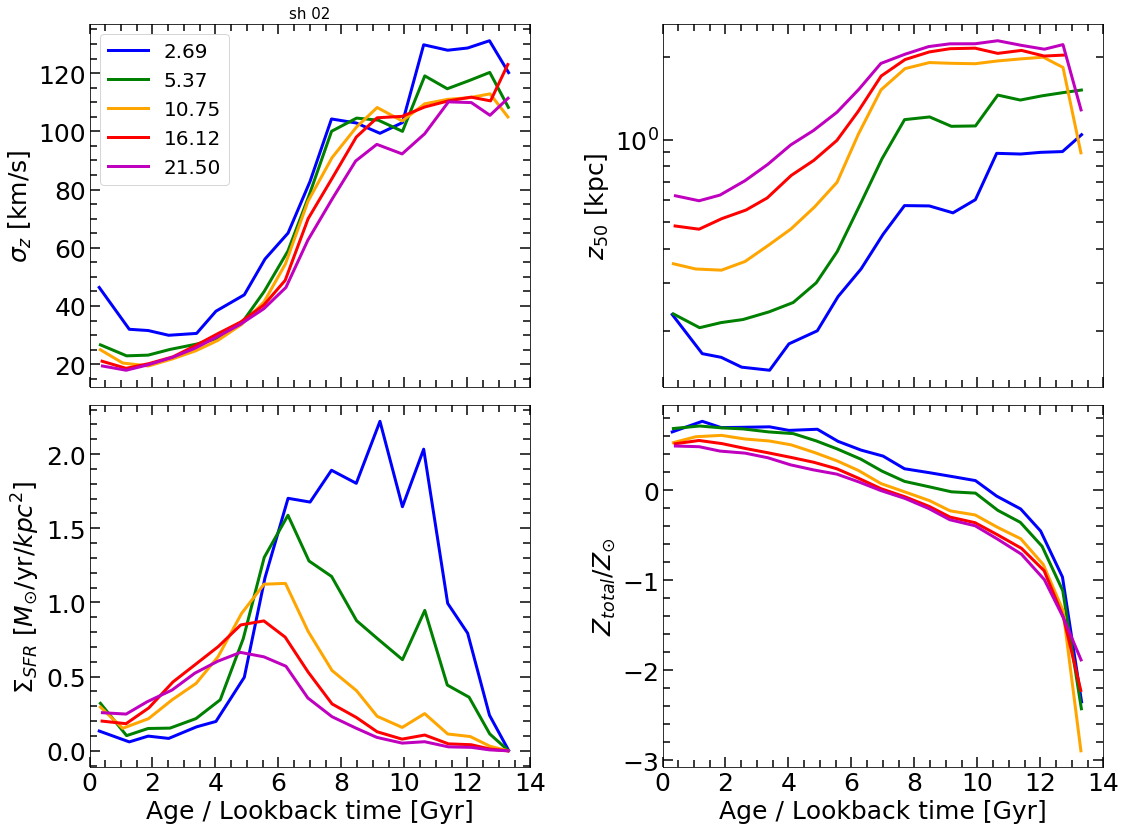

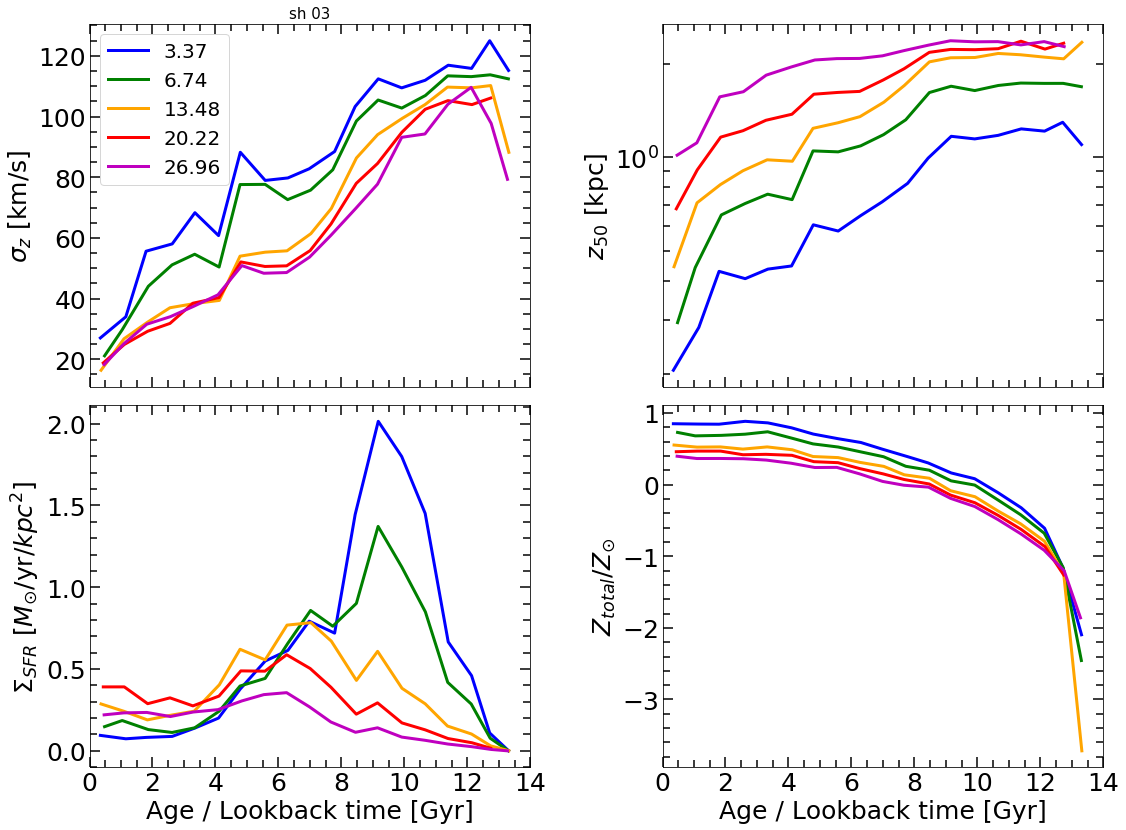

/z/omarioni/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10


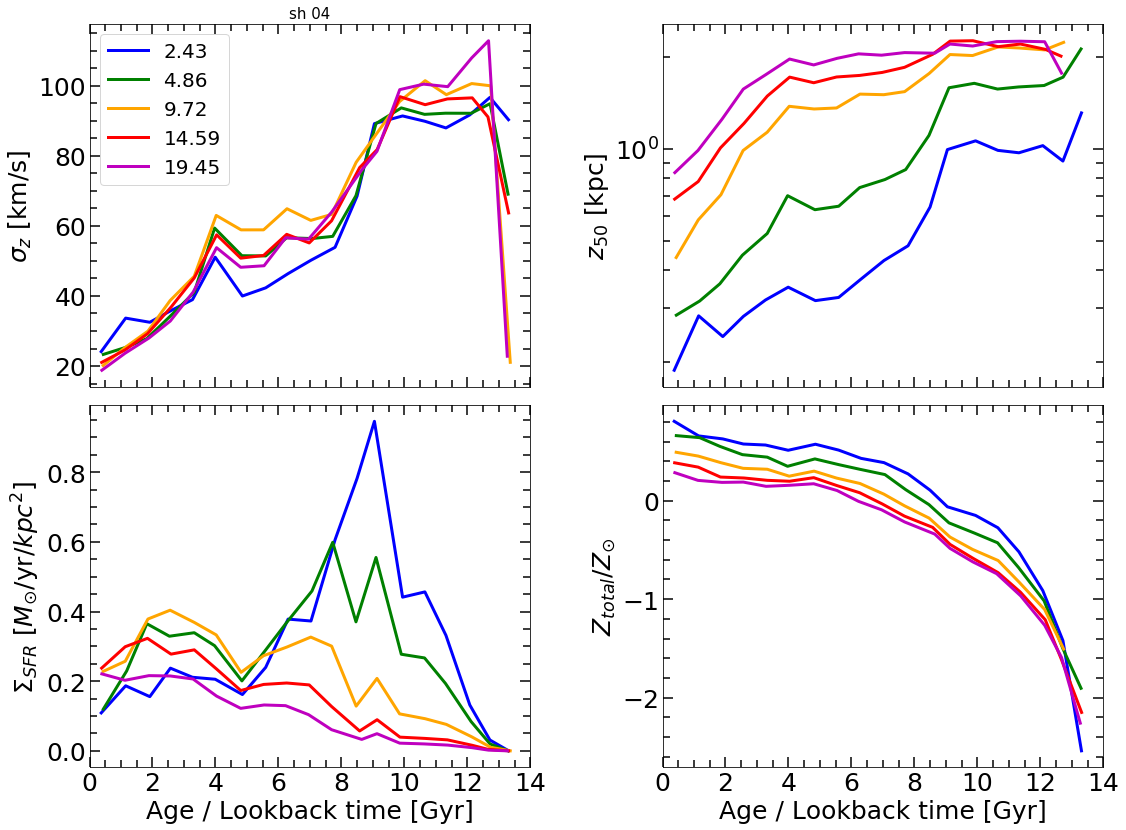

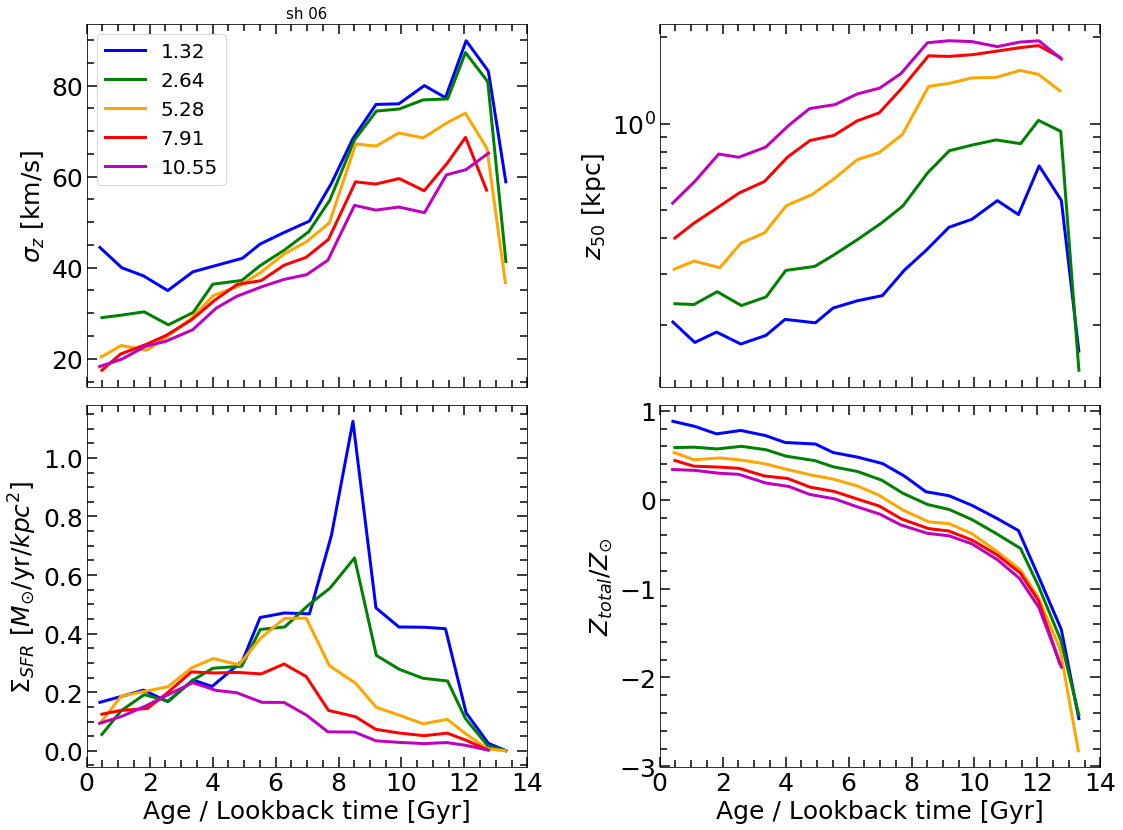

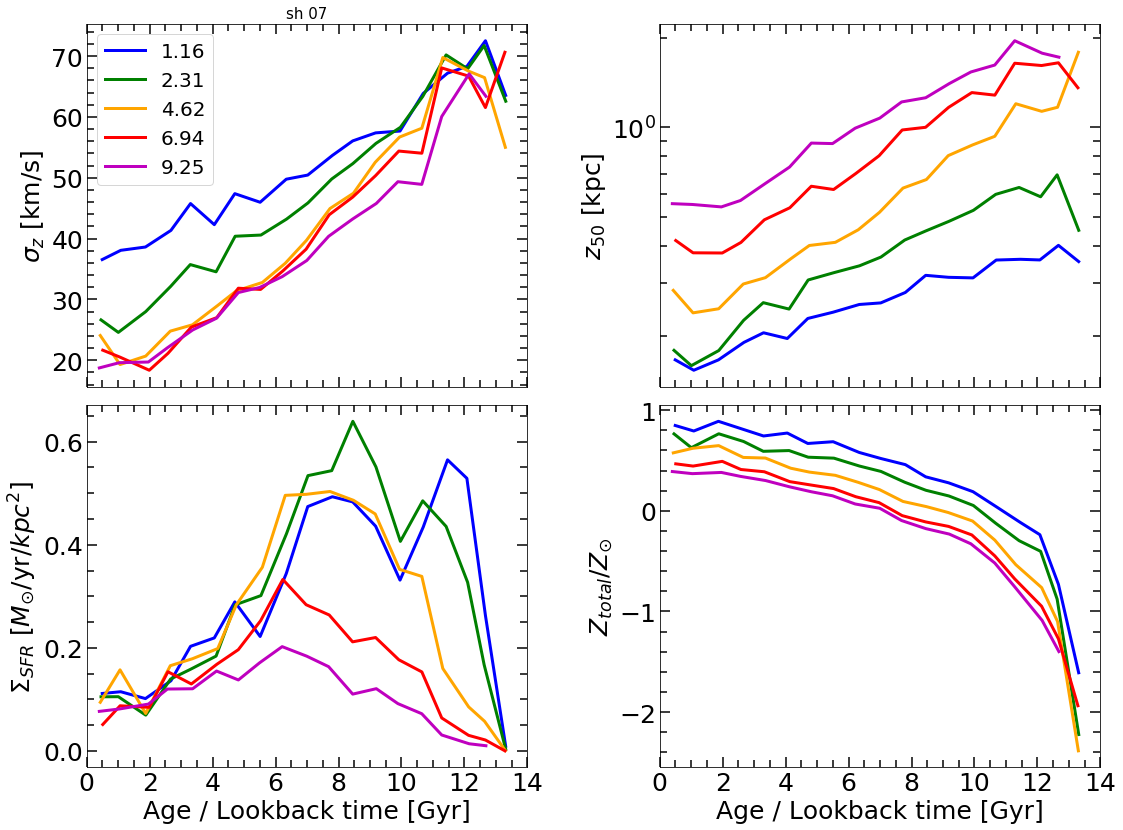

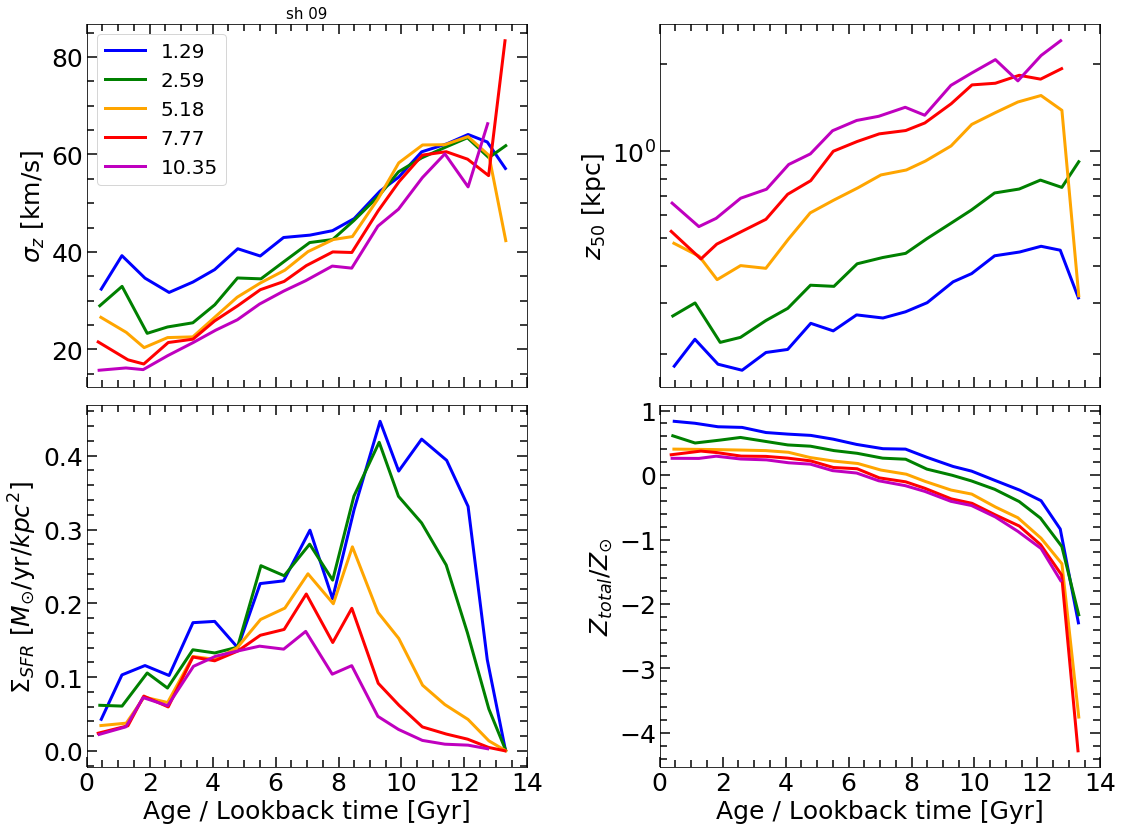

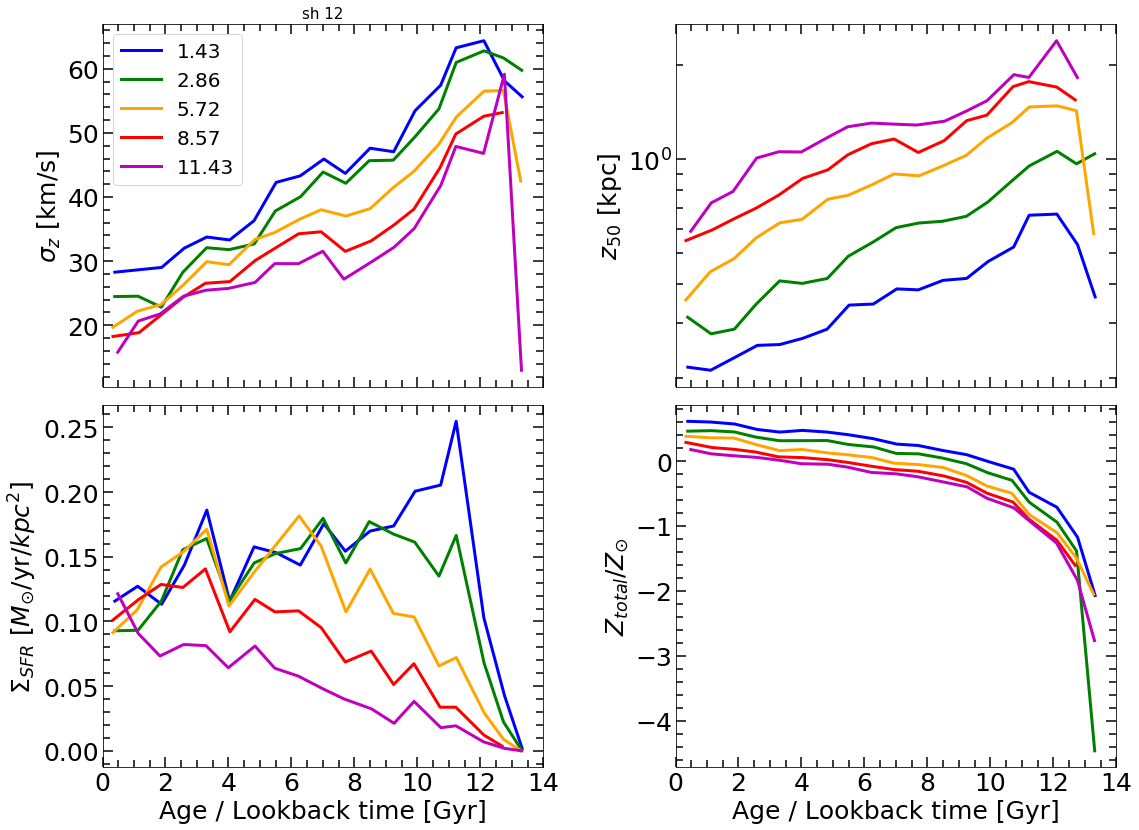

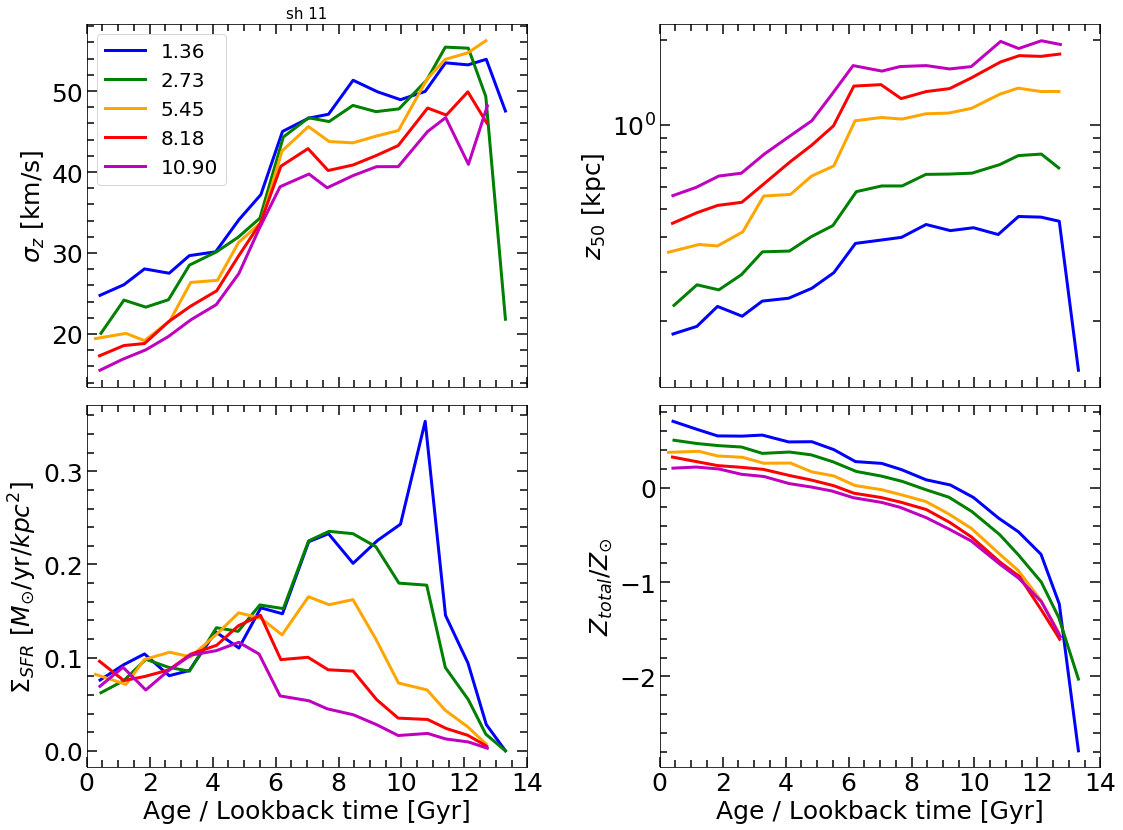

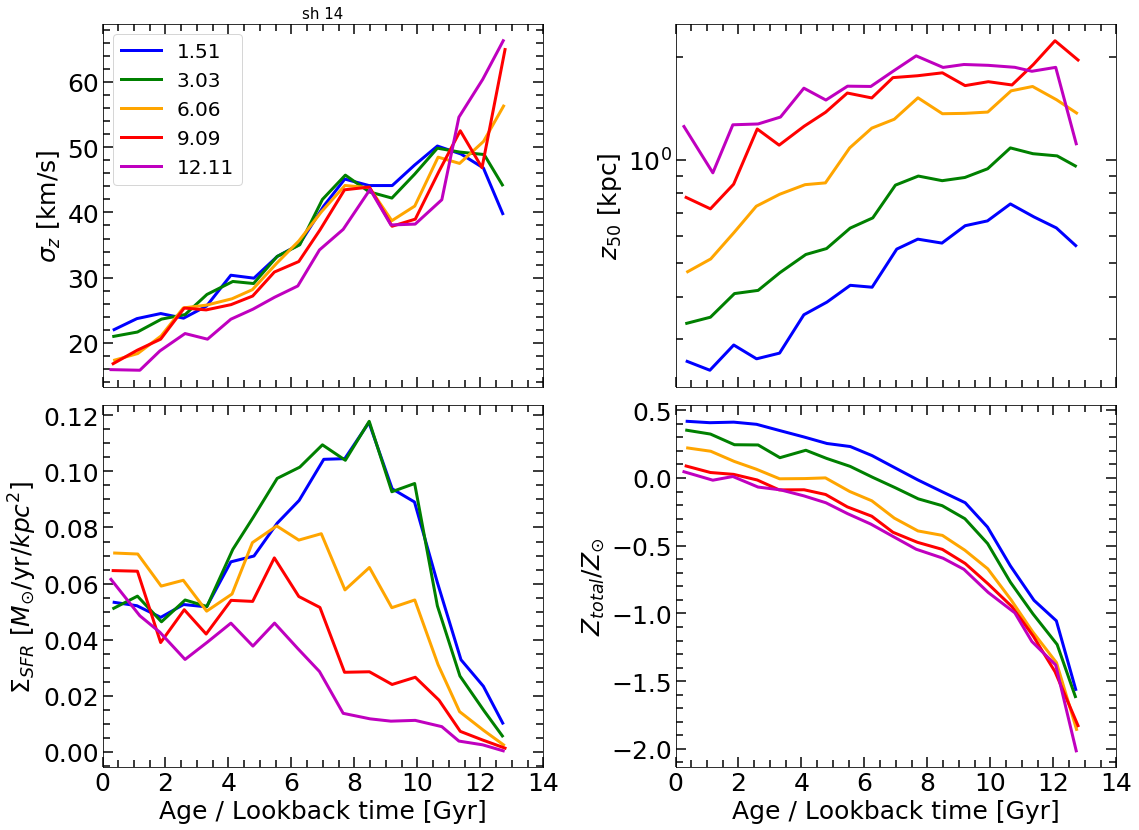

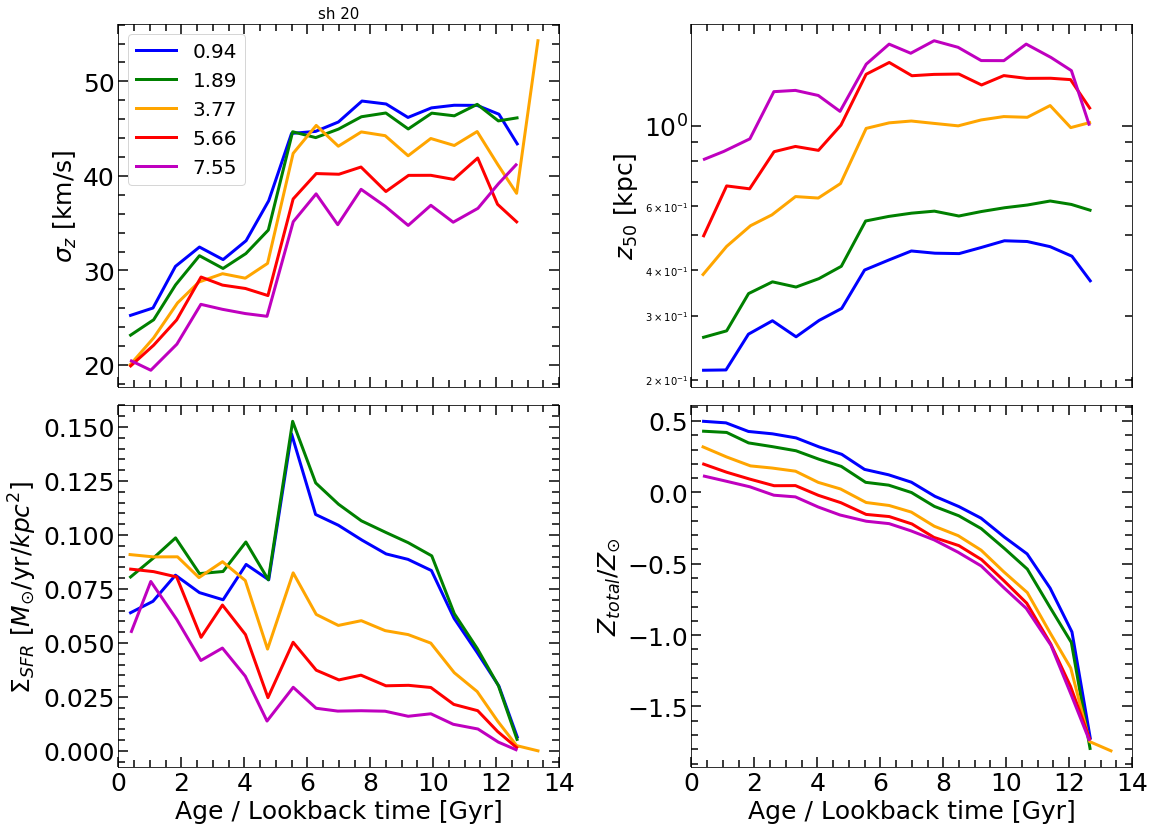

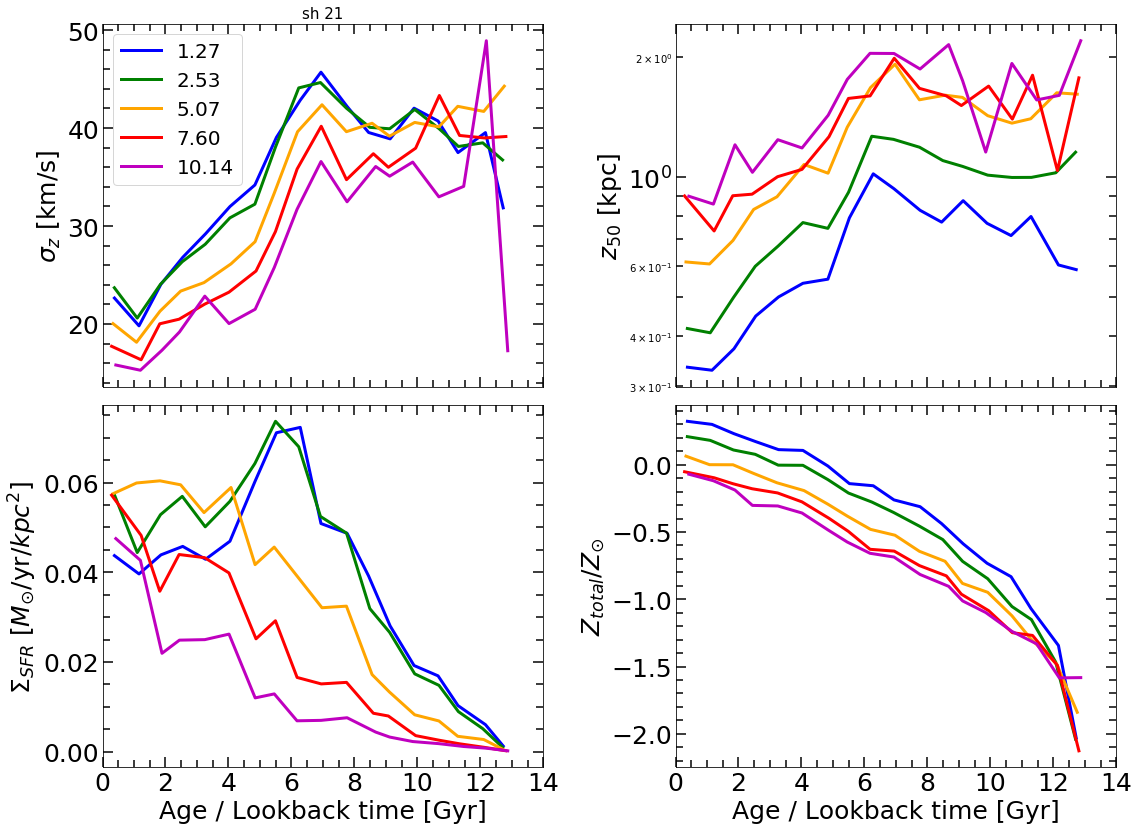

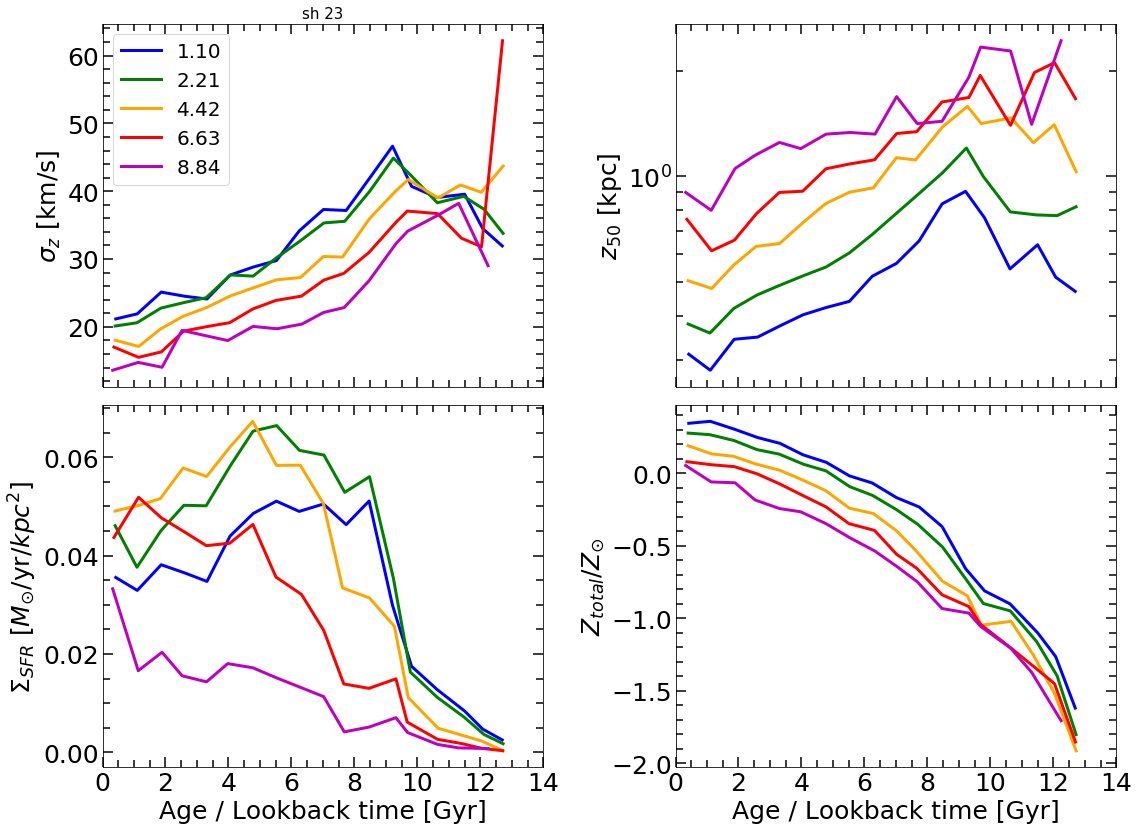

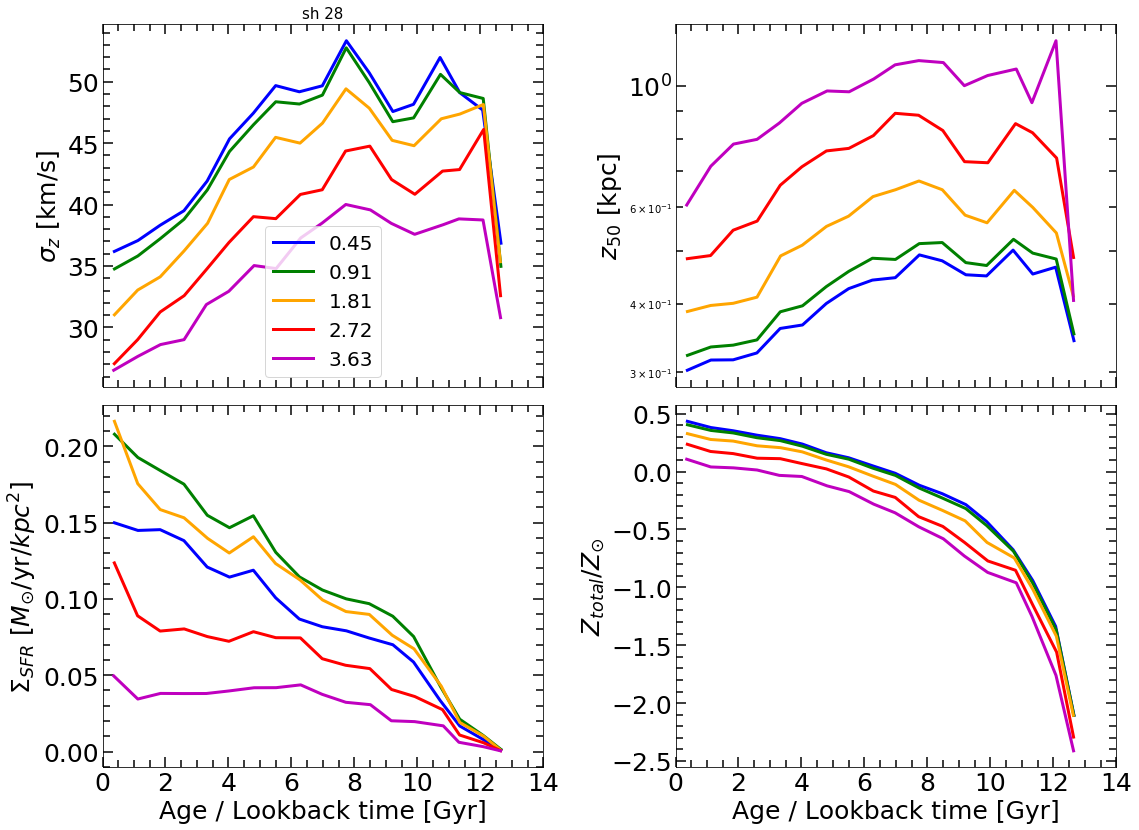

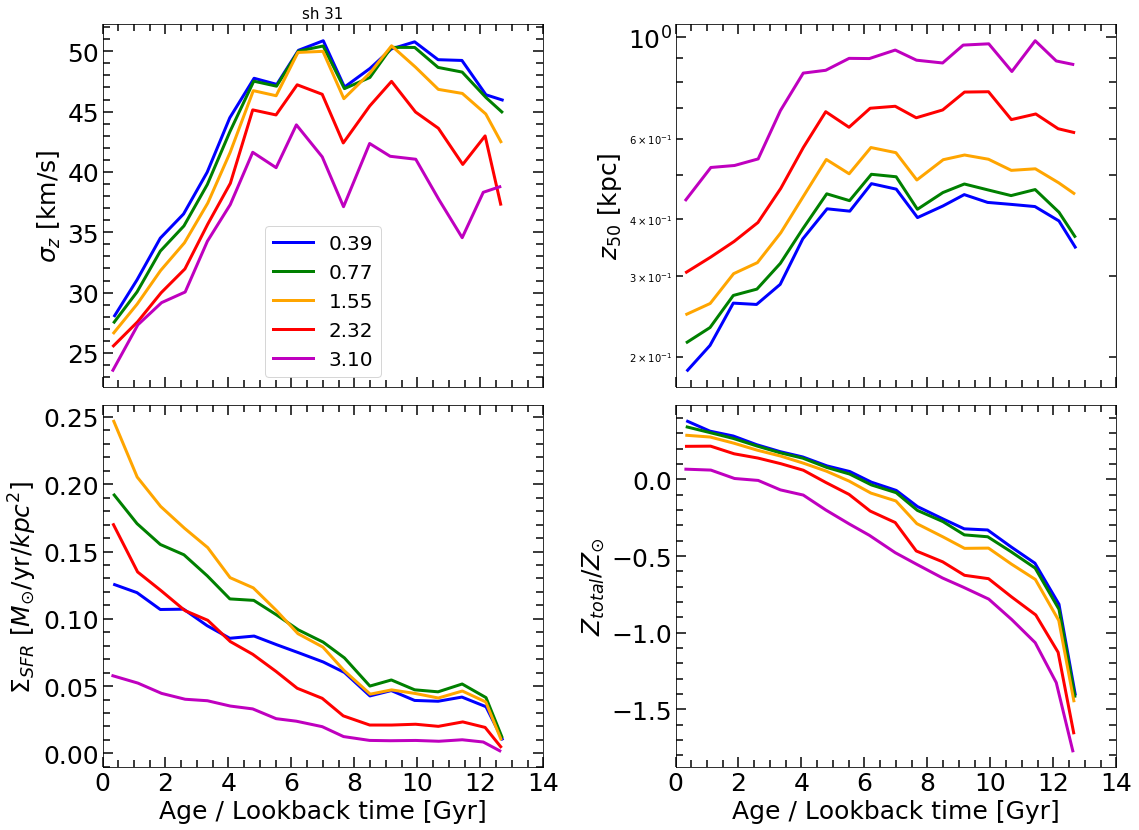

In [10]:
import numpy as np

ID = np.loadtxt('../_data/my_halos.dat')[:,0]

r50 = np.loadtxt('../_data/r50.dat')[:,1]

colors = ('b', 'g', 'orange', 'r', 'm')

for i in range(14): 
    Id = ''
    for aux in list(str('%d'%ID[i]))[-2:]:
        Id += aux
    
    radius = (r50[i]/4, r50[i]/2, r50[i], r50[i]+r50[i]/2, r50[i]*2)
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
    fig.subplots_adjust(bottom=0.10, left =0.10, right = 0.98,top=0.96, hspace=0.05, wspace=0.3)
    
    for k in range(5):
        data = np.loadtxt('../_data/Fig3.10/fig3.10_sh'+Id+'_r'+str('%s'%k)+'.dat')

        edad    = data[:,0]
        sigma_z = data[:,1]
        z_50    = data[:,2]        
        met     = data[:,3]        
        SFR     = data[:,4]
        SSFR    = data[:,4]
    
        ax[0,0].plot(edad,sigma_z,'-',lw=3, color= colors[k], label = str('%2.2f'%radius[k]) )
        ax[0,1].plot(edad,z_50,'-',lw=3, color= colors[k])
        ax[1,0].plot(edad,SSFR,'-',lw=3, color= colors[k])
        ax[1,1].plot(edad,np.log10(met),'-',lw=3, color= colors[k])
    
    ax[0,0].set_xlim(0,14)
    ax[0,0].set_xticks([0,2,4,6,8,10,12,14])
    ax[0,0].set_xticklabels([])
    ax[0,0].minorticks_on()
    ax[0,0].tick_params(labelsize=25)
    ax[0,0].tick_params('both', length=7, width=1.5,which='minor', direction='in', right=True,top=True)
    ax[0,0].tick_params('both', length=10, width=1.5,which='major', direction='in', right=True,top=True)
    ax[0,0].set_ylabel('$\sigma_z$ [km/s]',fontsize=25)
    ax[0,0].set_title('sh '+Id, fontsize=15)
    ax[0,0].legend(fontsize=20,fancybox=True)
    
    
    ax[0,1].set_xlim(0,14)
    ax[0,1].set_xticks([0,2,4,6,8,10,12,14])
    ax[0,1].set_xticklabels([])
    ax[0,1].set_yscale('log')
    ax[0,1].minorticks_on()
    ax[0,1].tick_params(labelsize=25)
    ax[0,1].tick_params('both', length=7, width=1.5,which='minor', direction='in', right=True,top=True)
    ax[0,1].tick_params('both', length=10, width=1.5,which='major', direction='in', right=True,top=True)
    ax[0,1].set_ylabel('$z_{50}$ [kpc]',fontsize=25)
    
    
    ax[1,0].set_xlim(0,14)
    ax[1,0].set_xticks([0,2,4,6,8,10,12,14])
    ax[1,0].minorticks_on()
    ax[1,0].tick_params(labelsize=25)
    ax[1,0].tick_params('both', length=7, width=1.5,which='minor', direction='in', right=True,top=True)
    ax[1,0].tick_params('both', length=10, width=1.5,which='major', direction='in', right=True,top=True)
    ax[1,0].set_ylabel('$\Sigma_{SFR}$ [$M_{\odot}$/yr/$kpc^2$]',fontsize=25)
    ax[1,0].set_xlabel('Age / Lookback time [Gyr]',fontsize=25)
    
    
    ax[1,1].set_xlim(0,14)
    ax[1,1].set_xticks([0,2,4,6,8,10,12,14])
    ax[1,1].minorticks_on()
    ax[1,1].tick_params(labelsize=25)
    ax[1,1].tick_params('both', length=7, width=1.5,which='minor', direction='in', right=True,top=True)
    ax[1,1].tick_params('both', length=10, width=1.5,which='major', direction='in', right=True,top=True)
    ax[1,1].set_ylabel('$Z_{total}$/$Z_{\odot}$',fontsize=25)
    ax[1,1].set_xlabel('Age / Lookback time [Gyr]',fontsize=25)
    

    plt.show()
    
    fig.savefig('../_imagenes/Fig3.10/Fig3.10_sh'+Id+'.png',dpi=100, xxbox_inches='tight')    